In [2]:
using Distributions, Random, Plots, CurveFit, LinearAlgebra, Richardson
Random.seed!(123)

TaskLocalRNG()

In [3]:
global const diffusivity = 1.00::Float64

global const endtime = 1.00::Float64
global const L = 1.00::Float64

global const dt = 1e-4::Float64
global const timesteps = Int64(div(endtime,dt)+1)::Int64

global const spacesteps = 51::Int64

global const u0 = 1::Int64
global const u0_tilda = (u0/spacesteps)::Float64

global const cfl = (diffusivity*(spacesteps*spacesteps)*dt)::Float64


0.2601

### Diffusion equation 
$$\frac{\partial u}{\partial t} = \frac{\partial}{\partial x} \left( D\frac{\partial u}{\partial x}\right)$$

In [5]:
function Crank_Nicolson_step(A, B, u_inint)
    return A\(B*u_inint)
end

function CN_absorbing_BC(u_init, alpha)
    #A * U_n+1 = B * U_n
    n_steps = spacesteps-2

    A = Tridiagonal(fill(-alpha/2, n_steps-1),
                    fill(1+alpha, n_steps),
                    fill(-alpha/2, n_steps-1))

    B = Tridiagonal(fill(alpha/2, n_steps-1),
                    fill(1-alpha, n_steps),
                    fill(alpha/2, n_steps-1))


    res = Array{Array{Float64, 1}, 1}(undef, timesteps)
    res[1] = u_init
    for i in 2:timesteps
        res[i] = reduce(vcat, [0, Crank_Nicolson_step(A,B,res[i-1][2:end-1]),0])
    end
    return res
end 

function CN_reflecting_BC(u_init, alpha)
    #A * U_n+1 = B * U_n
    n_steps = size(u_init,1)

    A = Tridiagonal(reduce(vcat, [fill(-alpha/2, n_steps-2), -alpha]),
                        fill(1+alpha, n_steps),
                        reduce(vcat, [-alpha, fill(-alpha/2, n_steps-2)]))
    
    B = Tridiagonal(reduce(vcat, [fill(alpha/2, n_steps-2), alpha]),
                        fill(1-alpha, n_steps),
                        reduce(vcat, [alpha, fill(alpha/2, n_steps-2)]))

    res = Array{Array{Float64, 1}, 1}(undef, timesteps)
    res[1] = u_init
    for i in 2:timesteps
        res[i] = Crank_Nicolson_step(A,B,res[i-1])
    end
    return res
end



CN_reflecting_BC (generic function with 1 method)

In [7]:
function unbounded(x0, x, t)
    return u0_tilda/sqrt(4 * pi * diffusivity * t) * exp(-(x-x0)^2/(4* diffusivity * t))
end

unbounded (generic function with 1 method)

In [8]:
x = reduce(vcat, [0, cumsum(fill(L/(spacesteps-1), spacesteps-1))])
t = LinRange(0,endtime, timesteps)

u_init = zeros(spacesteps)
u_init[div(spacesteps, 2)+1] = u0

u_res_absorbing = CN_absorbing_BC(u_init, cfl)

u_res_reflecting = CN_reflecting_BC(u_init, cfl)

u_anal_unbounded = unbounded.(0.5, x', t[2:end])


9999×51 Matrix{Float64}:
 2.16718e-272  4.11336e-251  1.05681e-230  …  4.11336e-251  2.16718e-272
 7.74166e-137  3.37276e-126  5.40611e-116     3.37276e-126  7.74166e-137
 1.08461e-91   1.34289e-84   8.53703e-78      1.34289e-84   1.08461e-91
 3.89087e-69   8.12123e-64   1.02819e-58      8.12123e-64   3.89087e-69
 1.29401e-55   2.33129e-51   2.81551e-47      2.33129e-51   1.29401e-55
 1.31596e-46   4.63049e-43   1.16751e-39   …  4.63049e-43   1.31596e-46
 3.53052e-40   3.86898e-37   3.18626e-34      3.86898e-37   3.53052e-40
 2.3195e-35    1.0597e-32    3.77057e-30      1.0597e-32    2.3195e-35
 1.28635e-31   2.97587e-29   5.51277e-27      2.97587e-29   1.28635e-31
 1.26506e-28   1.69802e-26   1.86605e-24      1.69802e-26   1.26506e-28
 ⋮                                         ⋱                ⋮
 0.00519797    0.00522352    0.00524815    …  0.00522352    0.00519797
 0.00519774    0.00522329    0.00524791       0.00522329    0.00519774
 0.00519751    0.00522306    0.00524768       0.00

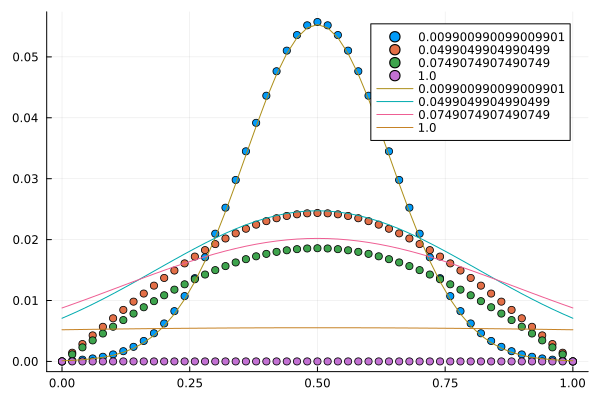

In [9]:
plot(scatter(x,u_res_absorbing[100], label = t[100]))
plot!(scatter!(x,u_res_absorbing[500], label = t[500]))
plot!(scatter!(x,u_res_absorbing[750], label = t[750]))
plot!(scatter!(x,u_res_absorbing[10000], label = t[10000]))

plot!(x, u_anal_unbounded[100, :], label = t[100])
plot!(x, u_anal_unbounded[500, :], label = t[500])
plot!(x, u_anal_unbounded[750, :], label = t[750])
plot!(x, u_anal_unbounded[end, :], label = t[end])

1.0002734616485385

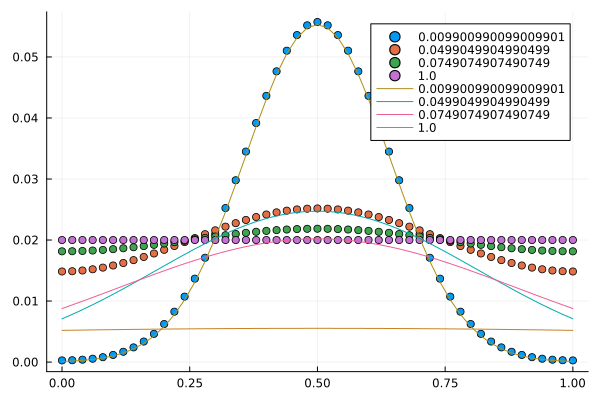

In [10]:
print(sum(u_res_reflecting[100]))
plot(scatter(x,u_res_reflecting[100], label = t[100]))
plot!(scatter!(x,u_res_reflecting[500], label = t[500]))
plot!(scatter!(x,u_res_reflecting[750], label = t[750]))
plot!(scatter!(x,u_res_reflecting[10000], label = t[10000]))

plot!(x, u_anal_unbounded[100, :], label = t[100])
plot!(x, u_anal_unbounded[500, :], label = t[500])
plot!(x, u_anal_unbounded[750, :], label = t[750])
plot!(x, u_anal_unbounded[end, :], label = t[end])
